In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
import spacy
import re,string,unicodedata
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.stem import LancasterStemmer,WordNetLemmatizer
from textblob import TextBlob
from sklearn.metrics import accuracy_score
import re
import warnings
import os
import pickle
os.chdir(r"C:\Users\aleen\Desktop\Data Science\Text Analytics\Exam Project\Data\IMDB")
warnings.filterwarnings('ignore')

## Import the Data

In [2]:
df = pd.read_csv('imdb50k.csv')
df.drop_duplicates(inplace=True)

## EDA

In [3]:
df.sentiment.value_counts(normalize=True)

positive    0.501876
negative    0.498124
Name: sentiment, dtype: float64

#### Obs: character length 

In [4]:
df['review_length'] = [len(t) for t in df.review]
df.head(3)

,review,sentiment,review_length
0,One of the other reviewers has mentioned that ...,positive,1761
1,A wonderful little production. <br /><br />The...,positive,998
2,I thought this was a wonderful way to spend ti...,positive,926


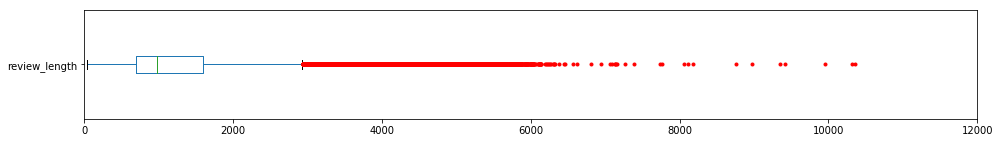

In [5]:
red = dict(markerfacecolor='r', markeredgecolor='r', marker='.')
df['review_length'].plot(kind='box', xlim=(0, 12000), vert=False, flierprops=red, figsize=(16,2));

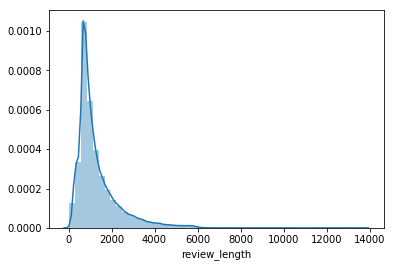

In [6]:
sns.distplot(df.review_length)

In [7]:
df.review.apply(lambda x: len(x.split(" "))).mean()

231.3391150014118

In [8]:
df.review_length.mean()

1310.5682304061959

## Pre-Processing

In [3]:
tokenizer=ToktokTokenizer()
stopword_list=nltk.corpus.stopwords.words('english')

#### Functions

In [4]:
def wordcloud(dataframe):
    wordcloud = WordCloud(width=1600, height=800, max_font_size=200, background_color="black",stopwords=stopword_list).generate(" ".join([str(i) for i in dataframe]))
    plt.figure(figsize = (12,10))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()
    
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    return text

def remove_accented_characters(text):
    text=unicodedata.normalize('NFKD',text).encode('ascii','ignore').decode('utf-8','ignore')
    return text

def remove_special_characters(text, remove_digits=True):
    if remove_digits == False:
        pattern = r'[^a-zA-z0-9\s]'
    else: pattern = r'[^a-zA-z\s]'
    text  = re.sub(pattern,'',text)
    return text

def simple_stemmer(text):
    ps=nltk.porter.PorterStemmer()
    text= ' '.join([ps.stem(word) for word in text.split()])
    return text

def remove_stopwords(text, is_lower_case=False):
    stop=set(stopwords.words('english'))
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text

def lowercase(text):
    text = text.lower()
    return text
    
def tokenize_text(text):
    text = tokenizer(text)
    text = text.lower()
    return text

from nltk.stem import WordNetLemmatizer

def lemmatize_text(text):
    lemma = WorntLemmatizer()
    text = ' '.join([lemma.stem(word) for word in text.split()])
    return text


In [11]:
#wordcloud(df.review)

In [12]:
#positive_reviews = [a for a in df.review == 'positive']

In [13]:
#foo = df[(df['sentiment']=='positive')]

In [14]:
#wordcloud(foo.review)

In [15]:
#foo = df[df['sentiment']=='negative']
#wordcloud(foo.review)

In [5]:
df['review'] = df['review'].apply(denoise_text)
df['review'] = df['review'].apply(remove_accented_characters)
df['review'] = df['review'].apply(remove_special_characters)
df['review'] = df['review'].apply(remove_stopwords)
df['review'] = df['review'].apply(simple_stemmer)

In [6]:
df['review'] = df['review'].apply(lowercase)

In [18]:
df.head()

,review,sentiment,review_length
0,one review mention watch oz episod youll hook ...,positive,1761
1,wonder littl product film techniqu unassum old...,positive,998
2,thought wonder way spend time hot summer weeke...,positive,926
3,basic there famili littl boy jake think there ...,negative,748
4,petter mattei love time money visual stun film...,positive,1317


### Splitting

In [7]:
reviews = df['review']
sentiments = df['sentiment']

from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()
sentiments = lb.fit_transform(sentiments)
                    
train_reviews = reviews[:40000]
train_sentiments = sentiments[:40000]
test_reviews = reviews[40000:]
test_sentiments = sentiments[40000:]

print(train_reviews.shape,train_sentiments.shape)
print(test_reviews.shape,test_sentiments.shape)

(40000,) (40000, 1)
(9582,) (9582, 1)


In [20]:
reviews.to_csv('imdb_reviews', encoding='utf-8')

In [21]:
np.savetxt("imdb_sentiments.csv", sentiments, delimiter=",")

### Bag of Words

In [162]:
cv=CountVectorizer(min_df=0,max_df=1,binary=False,ngram_range=(1,3))
cv_train_reviews=cv.fit_transform(train_reviews)

print('BOW_cv_train:',cv_train_reviews.shape)
print('BOW_cv_test:',cv_test_reviews.shape)
#vocab=cv.get_feature_names()-toget feature names

BOW_cv_train: (40000, 6139622)
BOW_cv_test: (9582, 6139622)


In [163]:
pickle.dump(cv.vocabulary_,open("cv.pkl","wb"))

In [18]:
from sklearn.feature_extraction.text import TfidfTransformer
transformer = TfidfTransformer()
loaded_vec = CountVectorizer(decode_error="replace",vocabulary=pickle.load(open("cv.pkl", "rb")))
#tv_train_reviews = transformer.fit_transform(loaded_vec.fit_transform(train_reviews))
#tv_test_reviews = transformer.fit_transform(loaded_vec.fit_transform(test_reviews))
tv_got_reviews = transformer.fit_transform(loaded_vec.fit_transform(got_reviews))

### TF IDF

In [8]:
tv=TfidfVectorizer(min_df=0.0,max_df=1.0,use_idf=True,ngram_range=(1,3),sublinear_tf=True)
tv_train_reviews=tv.fit_transform(train_reviews)
tv_test_reviews=tv.transform(test_reviews)

print('Tfidf_train:',tv_train_reviews.shape)
print('Tfidf_test:',tv_test_reviews.shape)

Tfidf_train: (40000, 6828874)
Tfidf_test: (9582, 6828874)


In [9]:
pickle.dump(tv.vocabulary_,open("tv.pkl","wb"))

In [19]:
from sklearn.feature_extraction.text import TfidfTransformer
transformer = TfidfTransformer()
loaded_vec = TfidfVectorizer(decode_error="replace",vocabulary=pickle.load(open("tv.pkl", "rb")))
#tv_train_reviews = transformer.fit_transform(loaded_vec.fit_transform(train_reviews))
#tv_test_reviews = transformer.fit_transform(loaded_vec.fit_transform(test_reviews))
tv_got_reviews = transformer.fit_transform(loaded_vec.fit_transform(got_reviews))
print('BOW_cv_test:',tv_got_reviews.shape)

BOW_cv_test: (15654, 6828874)


## Machine Learning Classification (Supervised)

In [20]:
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report,confusion_matrix

### 1) Logistic Regression

In [21]:
lr = LogisticRegression(penalty='l2',max_iter=300,C=1,random_state=32)

#### For BOW

In [26]:
lr.fit(cv_train_reviews, train_sentiments)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=300, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=32, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [27]:
lr_bow_predict = lr.predict(cv_test_reviews)

lr_bow_report = classification_report(test_sentiments, lr_bow_predict,target_names=['Positive','Negative'])
print(lr_bow_report)
print('##############################################\n')
lr_bow_cm = confusion_matrix(test_sentiments,lr_bow_predict,labels=[1,0])
print(lr_bow_cm)

              precision    recall  f1-score   support

    Positive       0.79      0.58      0.67      4756
    Negative       0.67      0.85      0.75      4826

   micro avg       0.72      0.72      0.72      9582
   macro avg       0.73      0.71      0.71      9582
weighted avg       0.73      0.72      0.71      9582

##############################################

[[4090  736]
 [1991 2765]]


In [28]:

val_pred = lr.predict(cv_test_reviews)
print(accuracy_score(test_sentiments, val_pred))

0.7154038822792737


#### For TFIDF

In [22]:
lr.fit(tv_train_reviews, train_sentiments)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=300, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=32, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [30]:
lr_tv_predict = lr.predict(tv_test_reviews)

lr_tv_report = classification_report(test_sentiments, lr_tv_predict,target_names=['Positive','Negative'])
print(lr_tv_report)
print('##############################################\n')
lr_tv_cm = confusion_matrix(test_sentiments, lr_tv_predict, labels=[1,0])
print(lr_tv_cm)

              precision    recall  f1-score   support

    Positive       0.88      0.88      0.88      4756
    Negative       0.88      0.89      0.88      4826

   micro avg       0.88      0.88      0.88      9582
   macro avg       0.88      0.88      0.88      9582
weighted avg       0.88      0.88      0.88      9582

##############################################

[[4277  549]
 [ 583 4173]]


In [23]:
val_pred = lr.predict(tv_test_reviews)
print(accuracy_score(test_sentiments, val_pred))

0.894385305781674


In [24]:
val_pred = lr.predict(tv_train_reviews)
print(accuracy_score(train_sentiments, val_pred))

0.950625


In [33]:
pickle.dump(lr, open('Logistic Regression Classifier', 'wb'))

### 2) Stochastic Gradient Descent

In [48]:
sgd = SGDClassifier(loss='hinge',n_iter=300,random_state=32)

#### For BOW

In [49]:
sgd.fit(cv_train_reviews, train_sentiments)

NameError: name 'cv_train_reviews' is not defined

In [36]:
sgd_bow_predict = sgd.predict(cv_test_reviews)

sgd_bow_report = classification_report(test_sentiments, sgd_bow_predict,target_names=['Positive','Negative'])
print(sgd_bow_report)
print('##############################################\n')
sgd_bow_cm = confusion_matrix(test_sentiments, sgd_bow_predict,labels=[1,0])
print(sgd_bow_cm)

              precision    recall  f1-score   support

    Positive       0.80      0.51      0.62      4756
    Negative       0.64      0.88      0.74      4826

   micro avg       0.69      0.69      0.69      9582
   macro avg       0.72      0.69      0.68      9582
weighted avg       0.72      0.69      0.68      9582

##############################################

[[4226  600]
 [2333 2423]]


In [37]:
val_pred = sgd.predict(cv_test_reviews)
print(accuracy_score(test_sentiments, val_pred))

0.6939052389897725


#### For TFIDF

In [50]:
sgd.fit(tv_train_reviews, train_sentiments)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=300, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=32, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [39]:
sgd_tv_predict = sgd.predict(tv_test_reviews)

sgd_tv_report = classification_report(test_sentiments, sgd_tv_predict, target_names=['Positive','Negative'])
print(sgd_tv_report)
print('##############################################\n')
sgd_tv_cm = confusion_matrix(test_sentiments, sgd_tv_predict, labels=[1,0])
print(sgd_tv_cm)

              precision    recall  f1-score   support

    Positive       0.89      0.87      0.88      4756
    Negative       0.87      0.89      0.88      4826

   micro avg       0.88      0.88      0.88      9582
   macro avg       0.88      0.88      0.88      9582
weighted avg       0.88      0.88      0.88      9582

##############################################

[[4309  517]
 [ 620 4136]]


In [51]:
val_pred = sgd.predict(tv_test_reviews)
print(accuracy_score(test_sentiments, val_pred))

0.8910457107075767


In [52]:
val_pred = sgd.predict(tv_train_reviews)
print(accuracy_score(train_sentiments, val_pred))

0.9405


In [42]:
pickle.dump(sgd, open('SGD Classifier', 'wb'))

### 3) Naive Bayes

In [28]:
nb = MultinomialNB(alpha=1, fit_prior=True)

#### BOW

In [29]:
nb.fit(cv_train_reviews, train_sentiments)

NameError: name 'cv_train_reviews' is not defined

In [45]:
nb_bow_predict = nb.predict(cv_test_reviews)

nb_bow_report = classification_report(test_sentiments, nb_bow_predict,target_names=['Positive','Negative'])
print(nb_bow_report)
print('##############################################\n')
nb_bow_cm = confusion_matrix(test_sentiments, nb_bow_predict,labels=[1,0])
print(nb_bow_cm)

              precision    recall  f1-score   support

    Positive       0.73      0.76      0.74      4756
    Negative       0.75      0.73      0.74      4826

   micro avg       0.74      0.74      0.74      9582
   macro avg       0.74      0.74      0.74      9582
weighted avg       0.74      0.74      0.74      9582

##############################################

[[3501 1325]
 [1151 3605]]


In [46]:
val_pred = nb.predict(cv_test_reviews)
print(accuracy_score(test_sentiments, val_pred))

0.7415988311417241


#### TF IDF

In [30]:
nb.fit(tv_train_reviews, train_sentiments)

MultinomialNB(alpha=1, class_prior=None, fit_prior=True)

In [48]:
nb_tv_predict = nb.predict(tv_test_reviews)

nb_tv_report = classification_report(test_sentiments, nb_tv_predict, target_names=['Positive','Negative'])
print(nb_tv_report)
print('##############################################\n')
nb_tv_cm = confusion_matrix(test_sentiments, nb_tv_predict, labels=[1,0])
print(nb_tv_cm)

              precision    recall  f1-score   support

    Positive       0.88      0.89      0.89      4756
    Negative       0.89      0.88      0.89      4826

   micro avg       0.89      0.89      0.89      9582
   macro avg       0.89      0.89      0.89      9582
weighted avg       0.89      0.89      0.89      9582

##############################################

[[4264  562]
 [ 524 4232]]


In [32]:
val_pred = nb.predict(tv_train_reviews)
print(accuracy_score(train_sentiments, val_pred))

0.9352


In [31]:
val_pred = nb.predict(tv_test_reviews)
print(accuracy_score(test_sentiments, val_pred))

0.8521185556251305


In [50]:
pickle.dump(nb, open('Naive Bayes Classifier', 'wb'))

### Random Forest

In [33]:
# Initialize a Random Forest classifier with 100 trees
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(max_depth = 30, n_estimators = 200, random_state = 1)

#### For BOW

In [52]:
rf.fit(cv_train_reviews, train_sentiments)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=30, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=None,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

In [53]:
rf_cv_predict = rf.predict(cv_test_reviews)

rf_cv_report = classification_report(test_sentiments, rf_cv_predict, target_names=['Positive','Negative'])
print(rf_cv_report)
print('##############################################\n')
rf_cv_cm = confusion_matrix(test_sentiments, rf_cv_predict, labels=[1,0])
print(rf_cv_cm)

              precision    recall  f1-score   support

    Positive       0.56      0.01      0.02      4756
    Negative       0.50      0.99      0.67      4826

   micro avg       0.50      0.50      0.50      9582
   macro avg       0.53      0.50      0.35      9582
weighted avg       0.53      0.50      0.35      9582

##############################################

[[4780   46]
 [4698   58]]


In [54]:
# evaluate accuracy
yPredRf = rf.predict(cv_test_reviews)
rfAcc = accuracy_score(test_sentiments, yPredRf)
rfAcc

0.5049050302650804

#### For TFIDF

In [41]:
rf.fit(tv_train_reviews, train_sentiments)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=30, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=None,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

In [56]:
rf_tv_predict = rf.predict(tv_test_reviews)

rf_tv_report = classification_report(test_sentiments, rf_tv_predict, target_names=['Positive','Negative'])
print(rf_tv_report)
print('##############################################\n')
rf_tv_cm = confusion_matrix(test_sentiments, rf_tv_predict, labels=[1,0])
print(rf_tv_cm)

              precision    recall  f1-score   support

    Positive       0.86      0.80      0.83      4756
    Negative       0.82      0.87      0.85      4826

   micro avg       0.84      0.84      0.84      9582
   macro avg       0.84      0.84      0.84      9582
weighted avg       0.84      0.84      0.84      9582

##############################################

[[4220  606]
 [ 936 3820]]


In [42]:
# evaluate accuracy
yPredRf = rf.predict(tv_train_reviews)
rfAcc = accuracy_score(train_sentiments, yPredRf)
rfAcc

0.9263

In [43]:
# evaluate accuracy
yPredRf = rf.predict(tv_test_reviews)
rfAcc = accuracy_score(test_sentiments, yPredRf)
rfAcc

0.8266541431851389

In [58]:
pickle.dump(rf, open('Random Forest Classifier', 'wb'))

### KNN Classifier

In [35]:
# run KNN
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors = 103)

In [36]:
knn.fit(tv_train_reviews, train_sentiments)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=103, p=2,
           weights='uniform')

In [90]:
knn_tv_predict = knn.predict(tv_test_reviews)

knn_tv_report = classification_report(test_sentiments, knn_tv_predict, target_names=['Positive','Negative'])
print(knn_tv_report)
print('##############################################\n')
knn_tv_cm = confusion_matrix(test_sentiments, rf_tv_predict, labels=[1,0])
print(knn_tv_cm)

              precision    recall  f1-score   support

    Positive       0.87      0.81      0.84      4756
    Negative       0.83      0.89      0.85      4826

   micro avg       0.85      0.85      0.85      9582
   macro avg       0.85      0.85      0.85      9582
weighted avg       0.85      0.85      0.85      9582

##############################################

[[4220  606]
 [ 936 3820]]


In [37]:
# evaluate accuracy
yPredknn = knn.predict(tv_test_reviews)
knnAcc = accuracy_score(test_sentiments, yPredknn )
knnAcc

0.7724900855771237

In [38]:
# evaluate accuracy
yPredknn = knn.predict(tv_train_reviews)
knnAcc = accuracy_score(train_sentiments, yPredknn )
knnAcc

0.783225

### Gradient Boosting Classifier

In [54]:
from sklearn.ensemble import GradientBoostingClassifier
gb = GradientBoostingClassifier(loss='deviance', n_estimators=50, verbose=1)

In [55]:
gb.fit(tv_train_reviews, train_sentiments)

      Iter       Train Loss   Remaining Time 
         1           1.3535           11.76m
         2           1.3267           11.42m
         3           1.3043           11.15m
         4           1.2848           10.90m
         5           1.2679           10.65m
         6           1.2525           10.41m
         7           1.2388           10.16m
         8           1.2257            9.92m
         9           1.2138            9.79m
        10           1.2025            9.66m
        20           1.1181            7.22m
        30           1.0615            4.80m
        40           1.0179            2.39m
        50           0.9827            0.00s


GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=50,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=1, warm_start=False)

In [60]:
# evaluate accuracy
yPredgb = gb.predict(tv_test_reviews)
gbAcc = accuracy_score(test_sentiments, yPredgb )
gbAcc

0.7824045084533501

In [61]:
# evaluate accuracy
yPredgb = gb.predict(tv_train_reviews)
gbAcc = accuracy_score(train_sentiments, yPredgb )
gbAcc

0.788275

## GOT

In [11]:
got = pd.read_csv('GOT', index_col=[0])

In [12]:
got.isna().sum()

review_rating    0
review_text      9
review_title     0
dtype: int64

In [13]:
got.dropna(inplace = True)

In [14]:
got.isna().sum()

review_rating    0
review_text      0
review_title     0
dtype: int64

In [15]:
got.head()

,review_rating,review_text,review_title
0,1,open credit chang credit nice radic chang icon...,We warmed up!
2,1,bad becom blank made got got lost sad ran book...,You can tell they have run out of books
4,1,rather slow episod build upcom war episod left...,"I like GOT, but...."
7,0,filler episod far stori goe thing signific plo...,Underwhelming
8,1,honour attend first episod last season belfast...,Best season premiere!


In [16]:
got.shape

(15654, 3)

In [17]:
got_reviews = got['review_text']
got_sentiments = got['review_rating']

In [145]:
got_reviews.isna().sum()

0

In [146]:
tv=TfidfVectorizer(min_df=0.0,max_df=1.0,use_idf=True,ngram_range=(1,3),sublinear_tf=True)
tv_reviews=tv.fit_transform(got_reviews)
tv_reviews=tv.transform(got_reviews)

print('Tfidf shape:',tv_reviews.shape)

Tfidf shape: (15654, 921958)


## GOT Accuracy

In [26]:
lr_pred = lr.predict(tv_got_reviews)
print(accuracy_score(got_sentiments, lr_pred))

0.7697074230228695


In [53]:
sgd_pred = sgd.predict(tv_got_reviews)
print(accuracy_score(got_sentiments, sgd_pred))

0.7635109237255654


In [39]:
nb_pred = nb.predict(tv_got_reviews)
print(accuracy_score(got_sentiments, nb_pred))

0.7366807205825987


In [44]:
rf_pred = rf.predict(tv_got_reviews)
print(accuracy_score(got_sentiments, rf_pred))

0.5996550402453047


In [40]:
knn_pred = knn.predict(tv_got_reviews)
print(accuracy_score(got_sentiments, knn_pred))

0.6908138494953366


In [59]:
gb_pred = gb.predict(tv_got_reviews)
print(accuracy_score(got_sentiments, gb_pred))

0.6056598952344449
